## Predicting Customer Churns

In [453]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [454]:
churn = pd.read_csv('online_retail.csv')
churn.head()

,Transaction_ID,Product_Code,Product_Title,Units_Sold,Transaction_Timestamp,Unit_Cost,Client_ID,Client_Region
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,01-12-2009 07:45,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,01-12-2009 07:45,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,01-12-2009 07:45,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,01-12-2009 07:45,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,01-12-2009 07:45,1.25,13085.0,United Kingdom


In [455]:
# Dataframe Shape
churn.shape

(525461, 8)

In [456]:
# Finding the number of missing values in each column
churn.isna().sum()

Transaction_ID                0
Product_Code                  0
Product_Title              2928
Units_Sold                    0
Transaction_Timestamp         0
Unit_Cost                     0
Client_ID                107927
Client_Region                 0
dtype: int64

## Data Preprocessing

### Handling Dupliactes

In [457]:
# Dropping duplicate rows
churn.drop_duplicates(inplace = True)

In [458]:
churn.shape

(518596, 8)

In [459]:
# Standardizing product codes
churn['Product_Code'] = churn['Product_Code'].astype(str)
churn['Product_Code'] = churn['Product_Code'].str.strip()
churn['Product_Code'] = churn['Product_Code'].str.replace(r'\s+', '', regex=True)
churn['Product_Code'] = churn['Product_Code'].str.upper()

In [460]:
# converting all product titles to lowercase
churn['Product_Title_Cleaned'] = churn['Product_Title'].astype(str)
churn['Product_Title_Cleaned'] = churn['Product_Title_Cleaned'].str.strip()
churn['Product_Title_Cleaned'] = churn['Product_Title_Cleaned'].str.replace(r'\s+', ' ', regex=True)
churn['Product_Title_Cleaned'] = churn['Product_Title_Cleaned'].str.lower()

In [461]:
churn.drop(columns=['Product_Title'], inplace=True)

In [463]:
junk_codes = ['', 'NAN', 'NA', '?', 'NONE', 'NULL']
# Replace them with 'junk'
churn['Product_Code'] = churn['Product_Code'].replace(junk_codes, 'JUNK')

In [464]:
churn['Product_Code'].fillna('No Code', inplace=True)

C:\Users\Jakkala\AppData\Local\Temp\ipykernel_16428\1710426677.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  churn['Product_Code'].fillna('No Code', inplace=True)


In [465]:
junk_code_count = (churn['Product_Code'] == 'JUNK').sum()
no_code_count = (churn['Product_Code'] == 'No Code').sum()
other_code_count = ((churn['Product_Code'] != 'JUNK') & (churn['Product_Code'] != 'No Code')).sum()
print(junk_code_count, no_code_count, other_code_count)

0 0 518596


In [466]:
# plotting a pie chart
labels=['Junk Codes', 'No Code', 'Other Codes']
sizes=[junk_code_count, no_code_count, other_code_count]

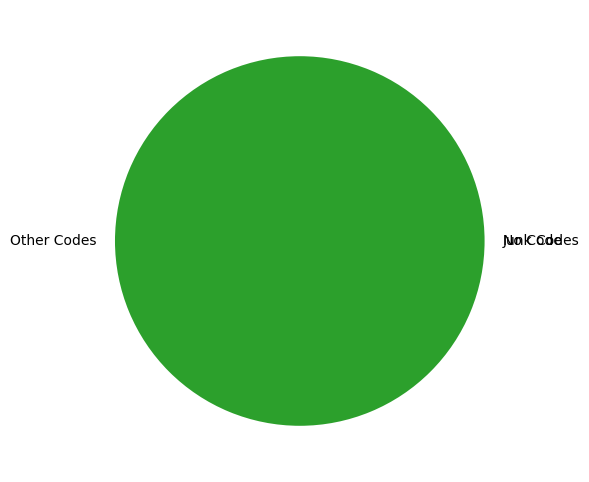

In [467]:
plt.figure(figsize=(10, 6))
plt.pie(sizes, labels=labels)
plt.show()

In [468]:
# All the product codes are standardized

### Handling Missing Values

In [469]:
churn['Client_ID'].fillna('Guest', inplace=True)

C:\Users\Jakkala\AppData\Local\Temp\ipykernel_16428\546381977.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  churn['Client_ID'].fillna('Guest', inplace=True)
C:\Users\Jakkala\AppData\Local\Temp\ipykernel_16428\546381977.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Guest' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  churn['Client_ID'].fillna('Guest', inplace=True)


In [470]:
churn.isna().sum()

Transaction_ID           0
Product_Code             0
Units_Sold               0
Transaction_Timestamp    0
Unit_Cost                0
Client_ID                0
Client_Region            0
Product_Title_Cleaned    0
dtype: int64

### Handling DataTypes

In [475]:
churn.dtypes

Transaction_ID                   object
Product_Code                     object
Units_Sold                        int64
Transaction_Timestamp    datetime64[ns]
Unit_Cost                       float64
Client_ID                        object
Client_Region                    object
Product_Title_Cleaned            object
dtype: object

In [474]:
churn['Transaction_Timestamp'] = pd.to_datetime(churn['Transaction_Timestamp'], format = '%d-%m-%Y %H:%M', dayfirst = True)

## EDA

In [476]:
churn.nunique()

Transaction_ID           28816
Product_Code              4480
Units_Sold                 825
Transaction_Timestamp    25296
Unit_Cost                 1606
Client_ID                 4384
Client_Region               40
Product_Title_Cleaned     4630
dtype: int64

In [479]:
# Checking if 1 transaction involves more than 1 customer which can be a problem
client_counts = churn.groupby('Transaction_ID')['Client_ID'].nunique()
multi_client_transactions = client_counts[client_counts > 1]
print(f"Number of transactions with multiple clients: {len(multi_client_transactions)}")

Number of transactions with multiple clients: 0


In [ ]:
# According to nunique values, 1 transaction timestamps can have more than 1 transaction IDs

## Feature Engineering